In [1]:
import gensim
import os
import collections
import smart_open
import random
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pprint import pprint
import numpy as np
from sklearn import svm
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint

d:\Anaconda3\envs\MLOntology\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
d:\Anaconda3\envs\MLOntology\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#global variabls

directory_path =  "D:/MLOntology/NCIt/"
data_path = directory_path + "data/"
vector_model_path = directory_path +"vectorModel/"
cnn_model_path = directory_path +"cnnModel/"


In [3]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

In [4]:
#read class label file
#create mapping from id to labels  
#iso-8859-1 , encoding="iso-8859-1"
conceptLabelDict={}
errors=[]

def read_label(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                conceptID = get_trailing_number(splitted[1])
                conceptLabelDict[conceptID] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

label_file = data_path + "ontClassLabels_owl_ncit.txt"
read_label(label_file)
print(conceptLabelDict["4863"])
print(conceptLabelDict["115117"])
print(errors)

prostate carcinoma
stage ia esophageal cancer ajcc v7
[]


In [5]:
conceptPairDict={}
errors=[]
conceptPairList=[]

def read_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                childID = get_trailing_number(splitted[1])
                parentID = get_trailing_number(splitted[2].replace("\r\n", ""))
                conceptPairList.append([childID, parentID , 1])
#                 conceptPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

pair_file = data_path + "ontHierarchy_owl_ncit.txt"
read_pair(pair_file)

checkpairs = conceptPairList[10:15]
print(checkpairs)
print(len(conceptPairList))

[['4861', '7318', 1], ['87152', '87150', 1], ['87153', '140032', 1], ['87154', '87153', 1], ['87155', '87153', 1]]
16533


In [6]:
conceptNotPairDict={}
conceptNotPairList=[]

def read_not_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==2:
                childID = get_trailing_number(splitted[0])
                notparentID = get_trailing_number(splitted[1].replace("\r\n", ""))
                conceptNotPairList.append([childID, notparentID, 0])
#                 conceptNotPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

notPair_file = data_path + "taxNotPairs_owl_ncit.txt"
read_not_pair(notPair_file)


first2pairs =conceptNotPairList[10:15]
print(first2pairs)
print(len(conceptNotPairList))

[['7918', '9151', 0], ['7918', '48612', 0], ['7918', '48613', 0], ['7918', '91231', 0], ['7918', '66753', 0]]
37147


In [ ]:
# In-place shuffle
random.shuffle(conceptPairList)
conceptPairList = conceptPairList[:len(conceptNotPairList)]

print(len(conceptPairList))

In [7]:
# In-place shuffle
random.shuffle(conceptNotPairList)
conceptNotPairList = conceptNotPairList[:len(conceptPairList)]

print(len(conceptNotPairList))

16533


In [8]:
#  PV-DBOW
vector_model_file = vector_model_path + "model0"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('4380', 0.6890608668327332),
 ('45750', 0.6798248887062073),
 ('4453', 0.6792981028556824),
 ('3615', 0.6784747838973999),
 ('45749', 0.6669068336486816),
 ('7744', 0.6627310514450073),
 ('116899', 0.662259578704834),
 ('45752', 0.6617138385772705),
 ('4494', 0.659558892250061),
 ('3841', 0.658550500869751)]


In [ ]:
vector_model.docvecs['7918']

In [24]:
# PV-DM seems better??
vector_model_file = vector_model_path + "model1"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('142823', 0.6030471324920654),
 ('6587', 0.4656713008880615),
 ('6721', 0.447739839553833),
 ('3263', 0.4254562556743622),
 ('7576', 0.4097474217414856),
 ('4370', 0.4087090790271759),
 ('3084', 0.404174268245697),
 ('4228', 0.39465904235839844),
 ('3810', 0.38257431983947754),
 ('139533', 0.38052302598953247)]


In [26]:
def readFromPairList(id_pair_list, id_notPair_list):
    pair_list = id_pair_list + id_notPair_list
    random.shuffle(pair_list)
    idpairs_list =[]
    label_list =[]
    for i, line in enumerate(pair_list):      
        idpairs_list.append([line[0], line[1]])
        label_list.append(line[2])
    return idpairs_list, label_list

idpairs_list, label_list= readFromPairList(conceptPairList, conceptNotPairList)

print(label_list[:20])

[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(idpairs_list, label_list, test_size = 0.2, shuffle= True)
print(X_train[:20])
print(X_validation[:20])
print(y_train[:20])
print(y_validation[:20])

[['4055', '5301'], ['5880', '87301'], ['4304', '121933'], ['7483', '4129'], ['9176', '36012'], ['5093', '66818'], ['66758', '3901'], ['66806', '2949'], ['4295', '36012'], ['133259', '133253'], ['6113', '65161'], ['4120', '2930'], ['96165', '3379'], ['3867', '2916'], ['8626', '65196'], ['4863', '7378'], ['27253', '8383'], ['67459', '65160'], ['38162', '4938'], ['2964', '7628']]
[['8416', '4565'], ['35370', '3355'], ['140009', '140008'], ['36052', '36032'], ['4531', '6198'], ['8784', '8423'], ['40010', '39997'], ['6783', '3786'], ['9306', '4867'], ['67459', '65195'], ['4946', '46068'], ['91226', '91223'], ['135530', '135527'], ['40102', '7072'], ['114581', '26813'], ['7625', '65153'], ['94800', '3471'], ['5368', '4938'], ['133413', '35180'], ['9048', '4005']]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]


In [28]:
def getVectorFromModel(concept_id, conceptLabelDict, model):
    if concept_id in model.docvecs:
        concept_vector= model.docvecs[concept_id]
    else:
        print("%s not found, get inferred vector "%(concept_id))
        concept_label = conceptLabelDict[concept_id]
        concept_vector= model.infer_vector(concept_label.split())
    return concept_vector

def getVector(line, conceptLabelDict, model):        
    a = getVectorFromModel(line[0], conceptLabelDict, model)
    b = getVectorFromModel(line[1], conceptLabelDict, model)
    c = np.array((a, b))
    c = c.T 
#     c = np.expand_dims(c, axis=2)
#     print(c.shape)
    return c

In [ ]:
def stackVector(vector):
    from numpy import dstack
    return dstack((vector, vector, vector))

In [29]:
n_channels=2 

def get_batches(x_samples, y_samples, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    shuffle(samples)
    for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]

        X_samples = []
        Y_samples= []
        for batch_sample in batch_samples:
            pair_list = batch_sample[0]
            data_vector = getVector(pair_list, conceptLabelDict, vector_model)
#                 data_vector = stackVector(data_vector)
#                 print(data_vector.shape)
            X_samples.append(data_vector)
            class_label = batch_sample[1] 
            Y_samples.append(class_label)

        X_samples = np.array(X_samples).astype('float32')
        Y_samples = np.eye(n_channels)[Y_samples]
#             print('one batch ready')
        yield shuffle(X_samples, Y_samples)

def get_batches(X, y, batch_size = 100):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [14]:
# Imports
import tensorflow as tf

# build the model??
batch_size = 200       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 100

n_classes = 2
n_channels = 2


graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    
with graph.as_default():
    # (batch, 128, 2) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')


with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



In [16]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [31]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 50 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_validation, y_validation, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/100 Iteration: 50 Train loss: 0.691962 Train acc: 0.545000
Epoch: 0/100 Iteration: 100 Train loss: 0.688805 Train acc: 0.570000
Epoch: 0/100 Iteration: 100 Validation loss: 0.688733 Validation acc: 0.576408
Epoch: 1/100 Iteration: 150 Train loss: 0.688029 Train acc: 0.535000
Epoch: 1/100 Iteration: 200 Train loss: 0.681203 Train acc: 0.595000
Epoch: 1/100 Iteration: 200 Validation loss: 0.680653 Validation acc: 0.581702
Epoch: 1/100 Iteration: 250 Train loss: 0.676377 Train acc: 0.590000
Epoch: 2/100 Iteration: 300 Train loss: 0.667527 Train acc: 0.575000
Epoch: 2/100 Iteration: 300 Validation loss: 0.670088 Validation acc: 0.586513
Epoch: 2/100 Iteration: 350 Train loss: 0.664468 Train acc: 0.605000
Epoch: 3/100 Iteration: 400 Train loss: 0.650612 Train acc: 0.615000
Epoch: 3/100 Iteration: 400 Validation loss: 0.662723 Validation acc: 0.594160
Epoch: 3/100 Iteration: 450 Train loss: 0.678024 Train acc: 0.540000
Epoch: 3/100 Iteration: 500 Train loss: 0.669215 Train acc: 0.55

Epoch: 28/100 Iteration: 3800 Train loss: 0.606698 Train acc: 0.680000
Epoch: 28/100 Iteration: 3800 Validation loss: 0.578047 Validation acc: 0.686870
Epoch: 28/100 Iteration: 3850 Train loss: 0.581237 Train acc: 0.665000
Epoch: 29/100 Iteration: 3900 Train loss: 0.629447 Train acc: 0.645000
Epoch: 29/100 Iteration: 3900 Validation loss: 0.584378 Validation acc: 0.686702
Epoch: 29/100 Iteration: 3950 Train loss: 0.569220 Train acc: 0.715000
Epoch: 30/100 Iteration: 4000 Train loss: 0.581193 Train acc: 0.720000
Epoch: 30/100 Iteration: 4000 Validation loss: 0.575849 Validation acc: 0.682311
Epoch: 30/100 Iteration: 4050 Train loss: 0.546277 Train acc: 0.715000
Epoch: 30/100 Iteration: 4100 Train loss: 0.612411 Train acc: 0.650000
Epoch: 30/100 Iteration: 4100 Validation loss: 0.574424 Validation acc: 0.685693
Epoch: 31/100 Iteration: 4150 Train loss: 0.587285 Train acc: 0.655000
Epoch: 31/100 Iteration: 4200 Train loss: 0.582704 Train acc: 0.700000
Epoch: 31/100 Iteration: 4200 Validat

Epoch: 56/100 Iteration: 7500 Train loss: 0.616504 Train acc: 0.640000
Epoch: 56/100 Iteration: 7500 Validation loss: 0.550714 Validation acc: 0.710483
Epoch: 56/100 Iteration: 7550 Train loss: 0.601500 Train acc: 0.690000
Epoch: 57/100 Iteration: 7600 Train loss: 0.509476 Train acc: 0.745000
Epoch: 57/100 Iteration: 7600 Validation loss: 0.545129 Validation acc: 0.715441
Epoch: 57/100 Iteration: 7650 Train loss: 0.578936 Train acc: 0.670000
Epoch: 57/100 Iteration: 7700 Train loss: 0.535649 Train acc: 0.750000
Epoch: 57/100 Iteration: 7700 Validation loss: 0.542569 Validation acc: 0.712794
Epoch: 58/100 Iteration: 7750 Train loss: 0.559597 Train acc: 0.720000
Epoch: 58/100 Iteration: 7800 Train loss: 0.584075 Train acc: 0.710000
Epoch: 58/100 Iteration: 7800 Validation loss: 0.542145 Validation acc: 0.714559
Epoch: 59/100 Iteration: 7850 Train loss: 0.599597 Train acc: 0.660000
Epoch: 59/100 Iteration: 7900 Train loss: 0.506584 Train acc: 0.740000
Epoch: 59/100 Iteration: 7900 Validat

Epoch: 83/100 Iteration: 11150 Train loss: 0.530446 Train acc: 0.715000
Epoch: 84/100 Iteration: 11200 Train loss: 0.430753 Train acc: 0.805000
Epoch: 84/100 Iteration: 11200 Validation loss: 0.523656 Validation acc: 0.730819
Epoch: 84/100 Iteration: 11250 Train loss: 0.530072 Train acc: 0.750000
Epoch: 84/100 Iteration: 11300 Train loss: 0.530390 Train acc: 0.750000
Epoch: 84/100 Iteration: 11300 Validation loss: 0.522668 Validation acc: 0.731071
Epoch: 85/100 Iteration: 11350 Train loss: 0.520418 Train acc: 0.725000
Epoch: 85/100 Iteration: 11400 Train loss: 0.570339 Train acc: 0.715000
Epoch: 85/100 Iteration: 11400 Validation loss: 0.522272 Validation acc: 0.732731
Epoch: 86/100 Iteration: 11450 Train loss: 0.484400 Train acc: 0.765000
Epoch: 86/100 Iteration: 11500 Train loss: 0.470192 Train acc: 0.795000
Epoch: 86/100 Iteration: 11500 Validation loss: 0.523117 Validation acc: 0.730525
Epoch: 86/100 Iteration: 11550 Train loss: 0.494446 Train acc: 0.790000
Epoch: 87/100 Iteration:

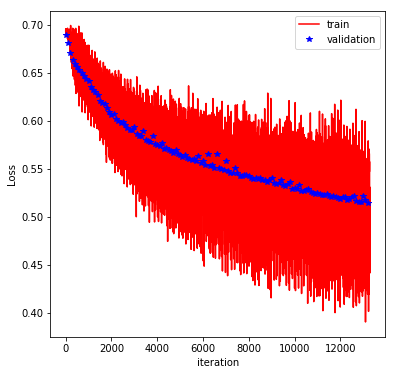

In [32]:
import matplotlib.pyplot as plt
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

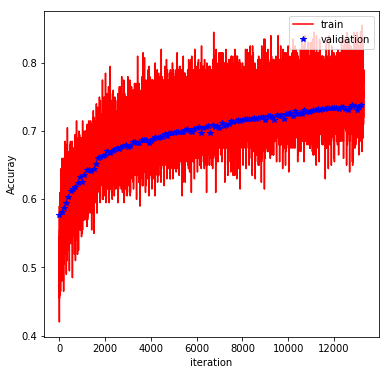

In [33]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [34]:
testStrings = '''4092,3677,1
4556,4555,1
4408,4242,1
62210,4133,1
4459,84509,1
6750,2896,1
3942,7158,1
3754,65157,1
3084,65157,1
6985,65157,1
3061,65157,1
27939,65157,1
4139,2915,1
3058,2937,1
4047,2937,1
7335,3010,1
3375,9343,1
4150,45921,1'''

X_test = []
y_test = []
X_test_reverse = []

for line in testStrings.splitlines():
    word = line.replace("\r\n", "").split(",")
    X_test.append([word[0], word[1]])
    X_test_reverse.append([word[1], word[0]])
    y_test.append(int(word[2]))
#     print(word)
#     print(vector_model.docvecs[word[0]])
#     print(vector_model.docvecs[word[1]])

print(len(X_test))

18


In [35]:
print(X_test)
print(y_test)

[['4092', '3677'], ['4556', '4555'], ['4408', '4242'], ['62210', '4133'], ['4459', '84509'], ['6750', '2896'], ['3942', '7158'], ['3754', '65157'], ['3084', '65157'], ['6985', '65157'], ['3061', '65157'], ['27939', '65157'], ['4139', '2915'], ['3058', '2937'], ['4047', '2937'], ['7335', '3010'], ['3375', '9343'], ['4150', '45921']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [36]:
for pair in X_test:
    if pair in X_train or pair in X_validation:
        print(pair, ' yes')
        X_test.remove(pair)

print(len(X_test))

['7335', '3010']  yes
17


In [37]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn\har.ckpt
Test accuracy: 0.235294
